In [88]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split

import shap

In [89]:
X, y = shap.datasets.adult(1000)
X_display, y_display = shap.datasets.adult(display=True, n_points=1000)
# create a train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)
d_train = lgb.Dataset(X_train, label=y_train)
d_test = lgb.Dataset(X_test, label=y_test)

In [90]:
params = {
    "max_bin": 512,
    "learning_rate": 0.05,
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "binary_logloss",
    "num_leaves": 10,
    "verbose": -1,
    "min_data": 100,
    "boost_from_average": True,
    "early_stopping_round": 50,
}

model = lgb.train(
    params,
    d_train,
    10000,
    valid_sets=[d_test],
)

In [91]:
explainer = shap.TreeExplainer(model)
shap_values = explainer(X)

## SHAP Summary Plot

Rather than use a typical feature importance bar chart, we use a density scatter plot of SHAP values for each feature to identify how much impact each feature has on the model output for individuals in the validation dataset. Features are sorted by the sum of the SHAP value magnitudes across all samples. It is interesting to note that the relationship feature has more total model impact than the capital gain feature, but for those samples where capital gain matters it has more impact than age. In other words, capital gain effects a few predictions by a large amount, while age effects all predictions by a smaller amount.

Note that when the scatter points don't fit on a line they pile up to show density, and the color of each point represents the feature value of that individual.

In [92]:
X.head()

,Age,Workclass,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country
0,39.0,State-gov,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States
1,50.0,Self-emp-not-inc,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States
2,38.0,Private,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States
3,53.0,Private,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States
4,28.0,Private,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba


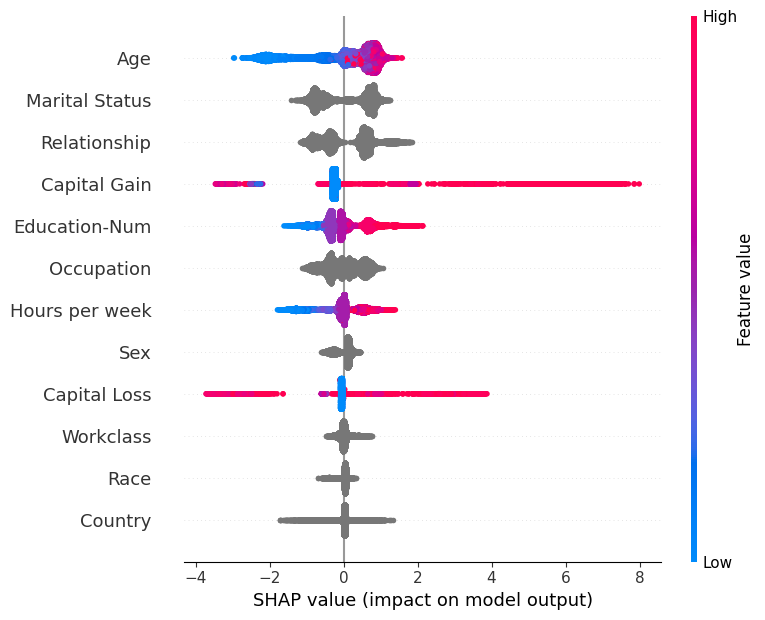

In [93]:
shap.summary_plot(shap_values, X)

In [94]:
mean_shape_values = shap_values.mean(0).values
feature_importance_by_shapley = dict((zip(X.columns, mean_shape_values)))
feature_importance_by_shapley

{'Age': np.float64(0.053596852249146516),
 'Workclass': np.float64(0.0023486532548057802),
 'Education-Num': np.float64(-0.015593042380375993),
 'Marital Status': np.float64(-0.008950971611155899),
 'Occupation': np.float64(-0.0029202446679030816),
 'Relationship': np.float64(-0.002397453958902585),
 'Race': np.float64(-0.0023307856825125124),
 'Sex': np.float64(0.003273141219512189),
 'Capital Gain': np.float64(-0.0021475676561347095),
 'Capital Loss': np.float64(-0.013582637225567778),
 'Hours per week': np.float64(-0.009728303995708771),
 'Country': np.float64(-0.000715991477026647)}

## SHAP Dependence Plots

SHAP dependence plots show the effect of a single feature across the whole dataset. They plot a feature's value vs. the SHAP value of that feature across many samples. SHAP dependence plots are similar to partial dependence plots, but account for the interaction effects present in the features, and are only defined in regions of the input space supported by data. The vertical dispersion of SHAP values at a single feature value is driven by interaction effects, and another feature is chosen for coloring to highlight possible interactions.

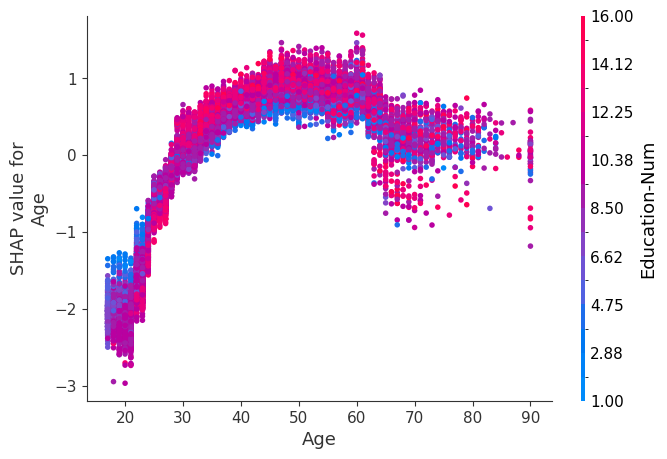

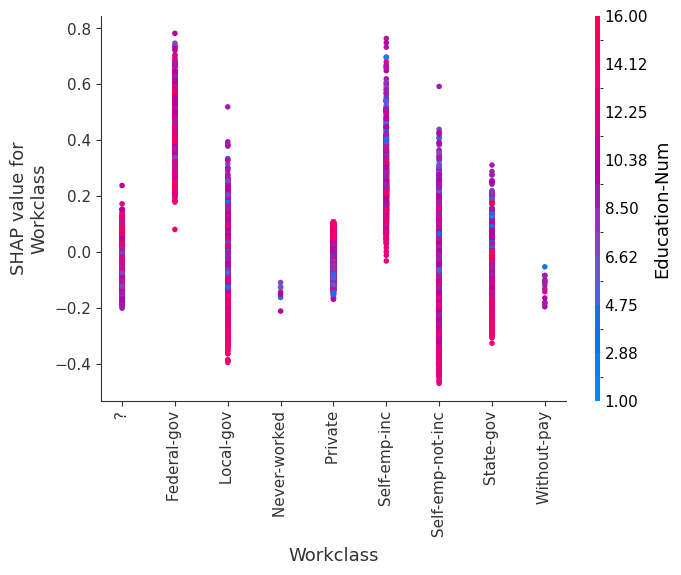

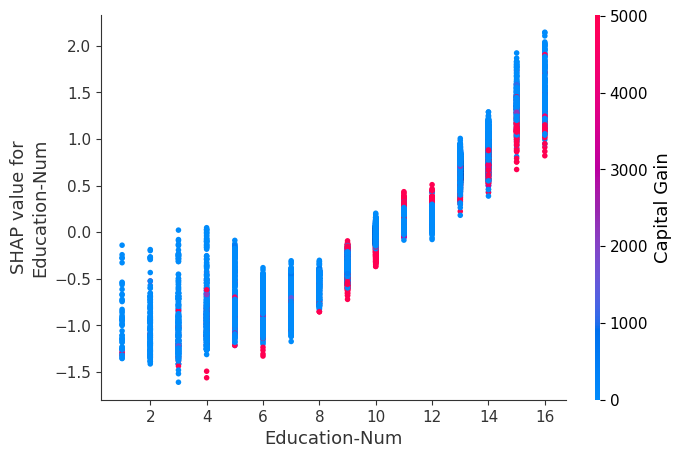

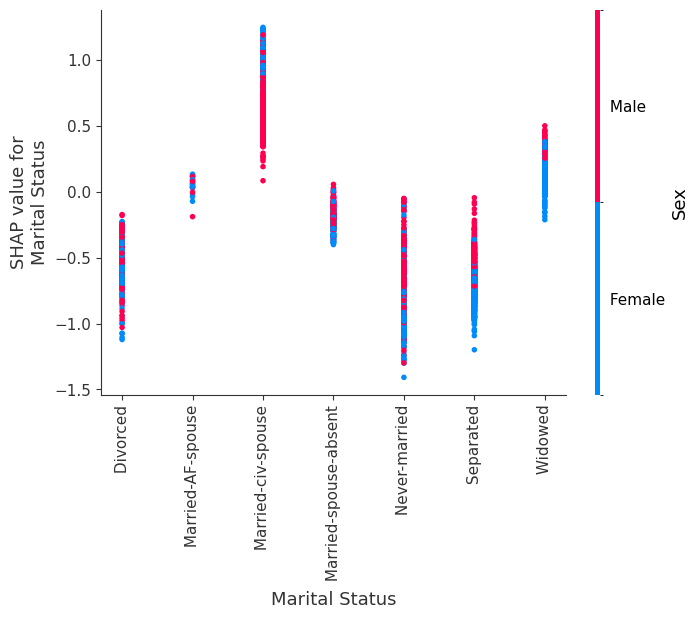

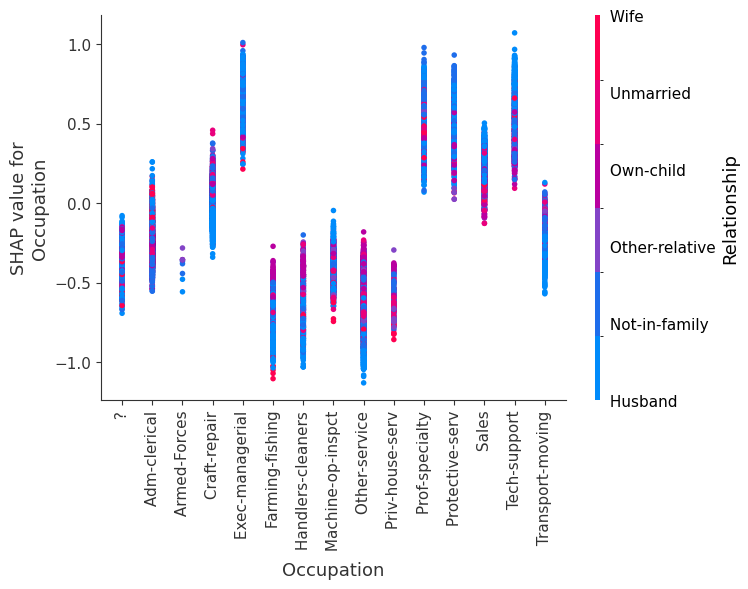

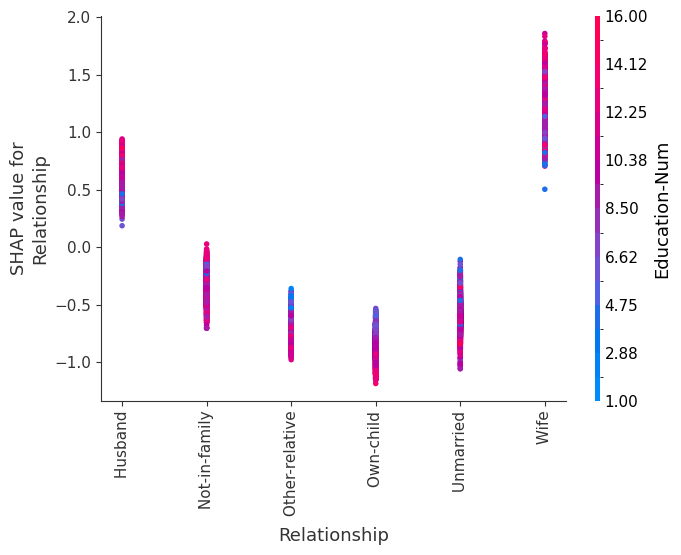

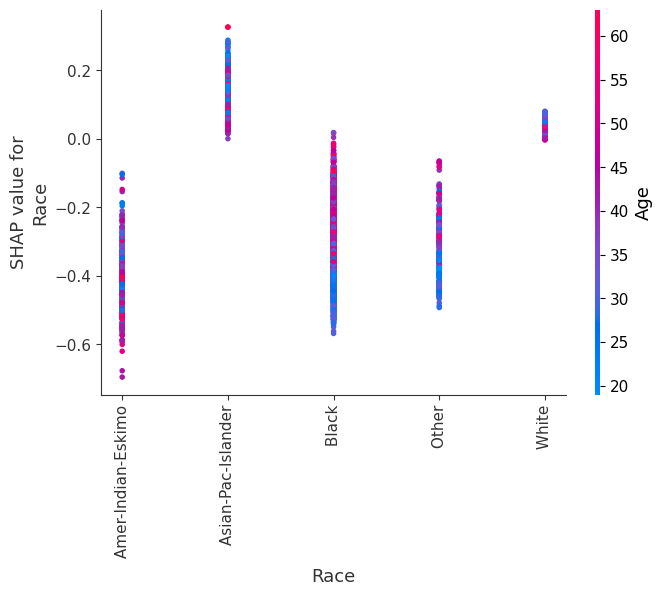

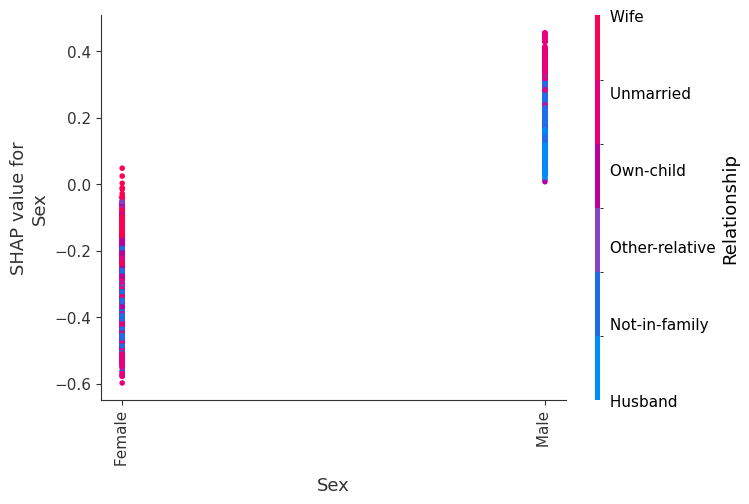

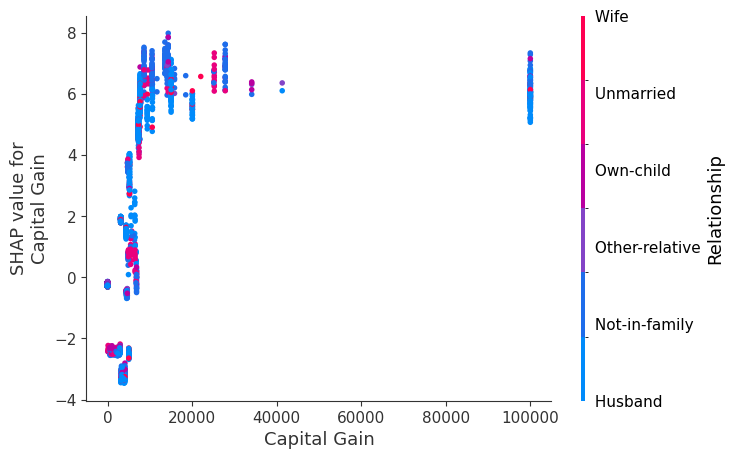

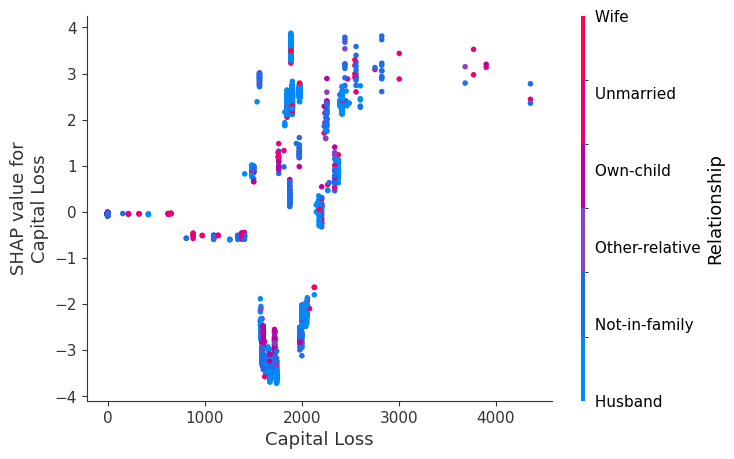

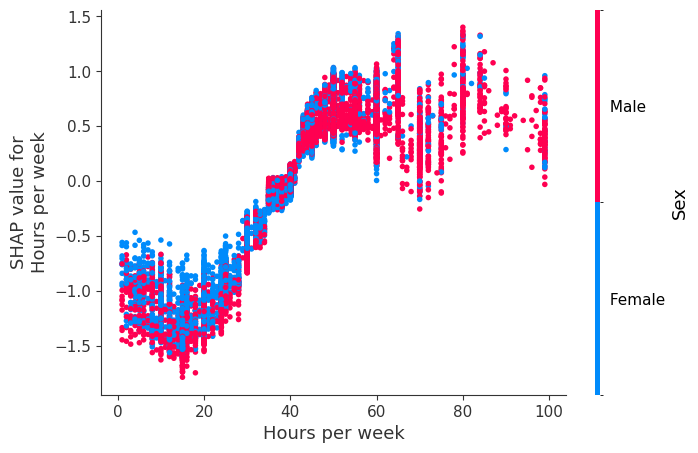

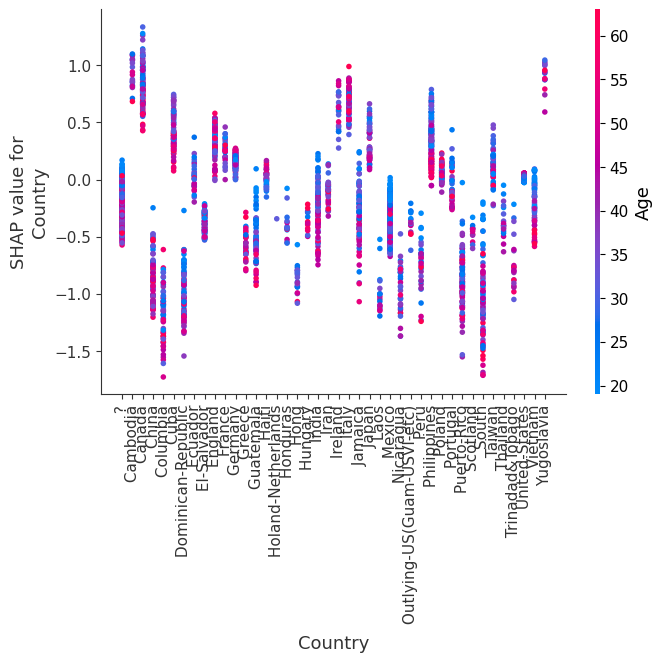

In [95]:
for name in X_train.columns:
    shap.dependence_plot(name, shap_values.values, X, display_features=X_display)

### Train a model with only two leaves per tree and hence no interaction terms between features

Forcing the model to have no interaction terms means the effect of a feature on the outcome does not depend on the value of any other feature. This is reflected in the SHAP dependence plots below as no vertical spread. A vertical spread reflects that a single value of a feature can have different effects on the model output depending on the context of the other features present for an individual. However, for models without interaction terms, a feature always has the same impact regardless of what other attributes an individual may have.

One of the benefits of SHAP dependence plots over traditional partial dependence plots is this ability to distigush between between models with and without interaction terms. In other words, SHAP dependence plots give an idea of the magnitude of the interaction terms through the vertical variance of the scatter plot at a given feature value.

In [96]:
params = {
    "max_bin": 512,
    "learning_rate": 0.1,
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "binary_logloss",
    "num_leaves": 2,
    "verbose": -1,
    "min_data": 100,
    "boost_from_average": True,
    "early_stopping_round": 50,
}

model_ind = lgb.train(
    params,
    d_train,
    20000,
    valid_sets=[d_test],
)

In [97]:
explainer = shap.TreeExplainer(model_ind)
shap_values_ind = explainer(X)

Note that the interaction color bars below are meaningless for this model because it has no interactions.

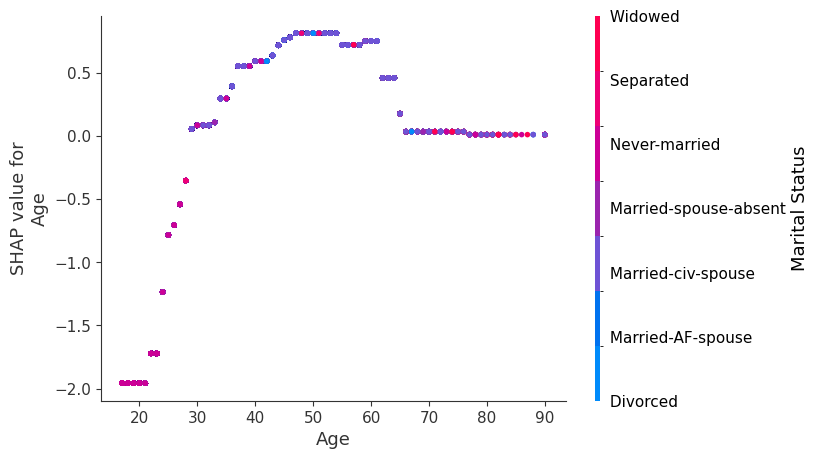

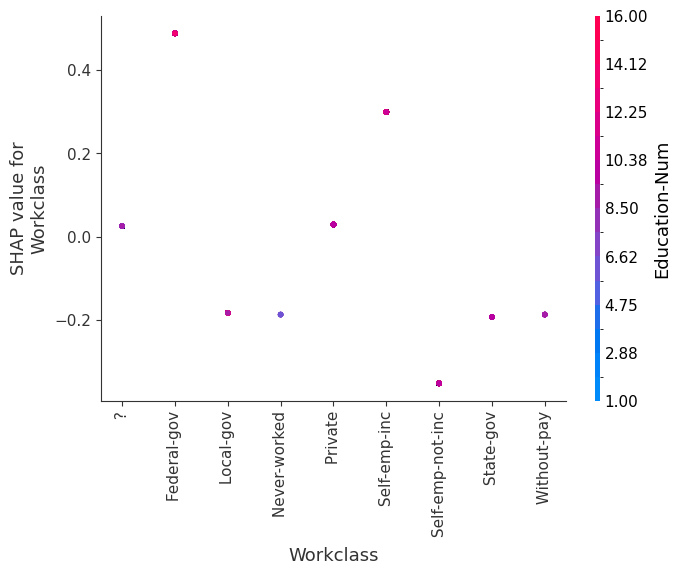

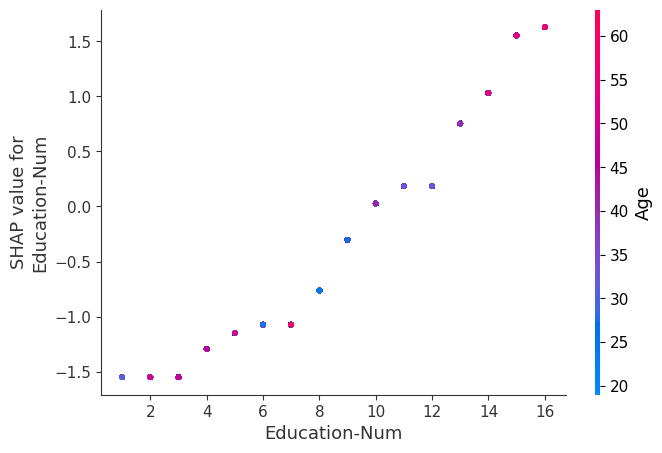

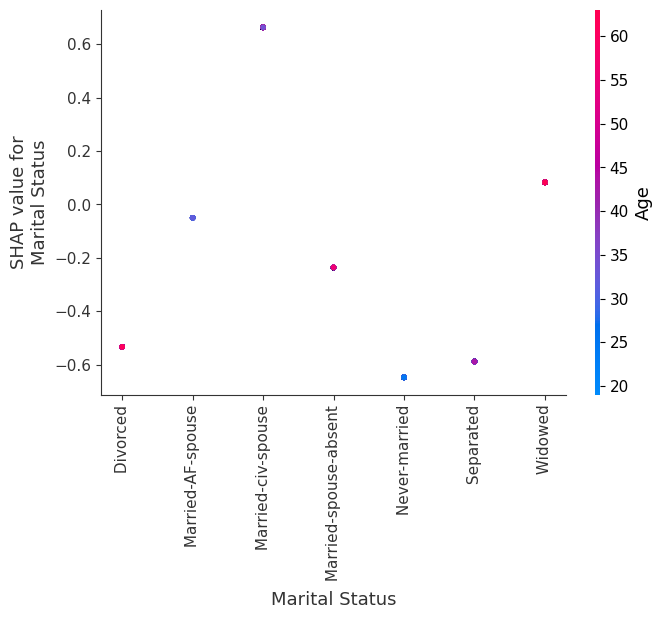

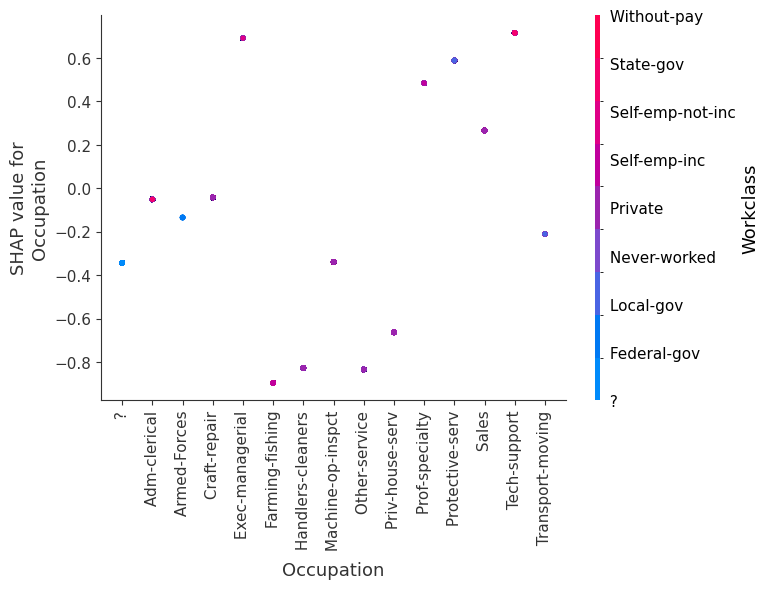

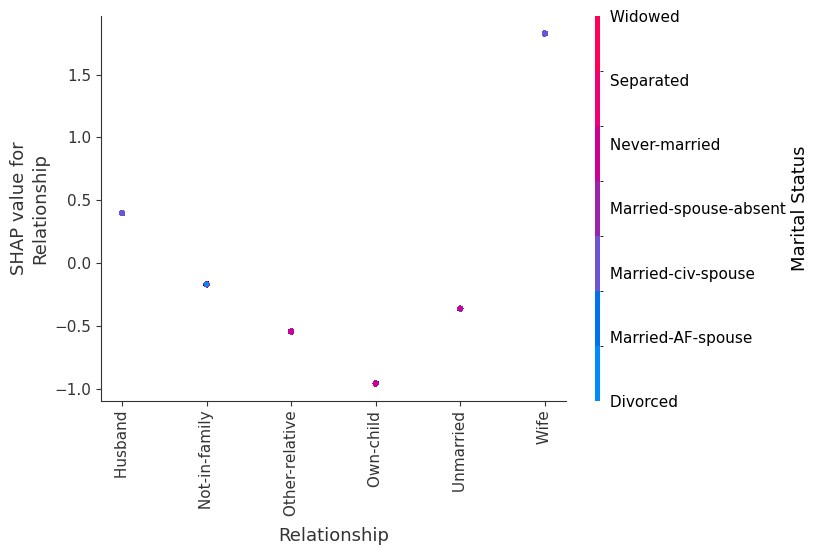

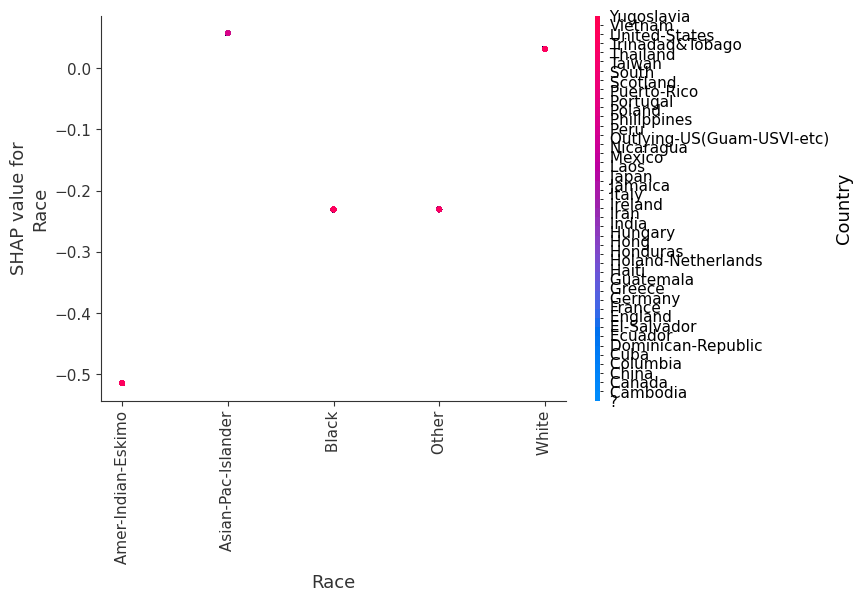

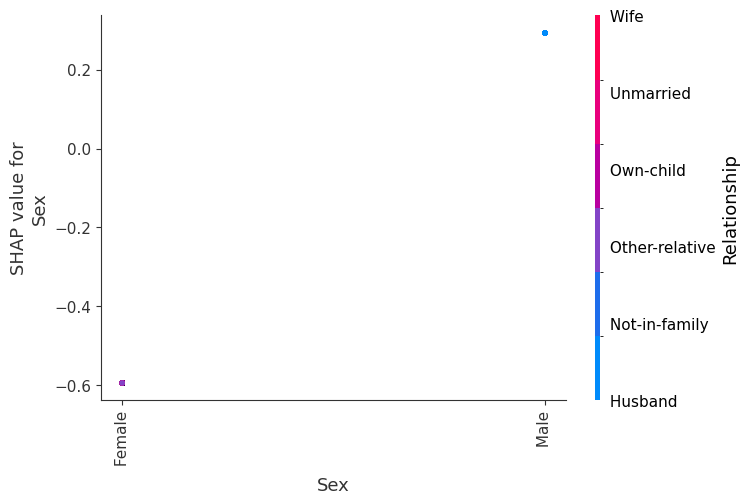

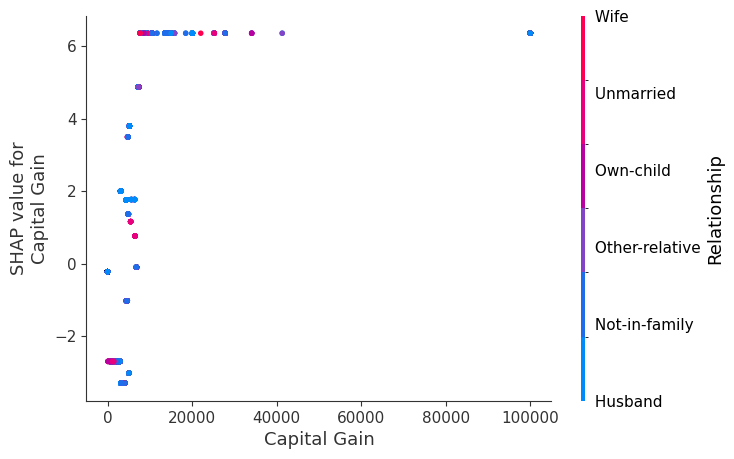

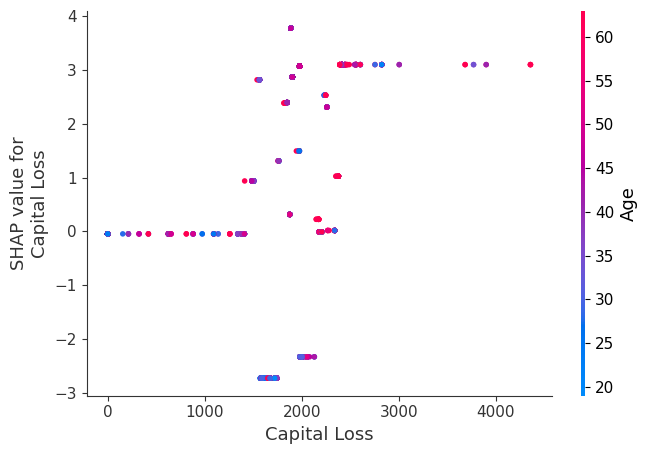

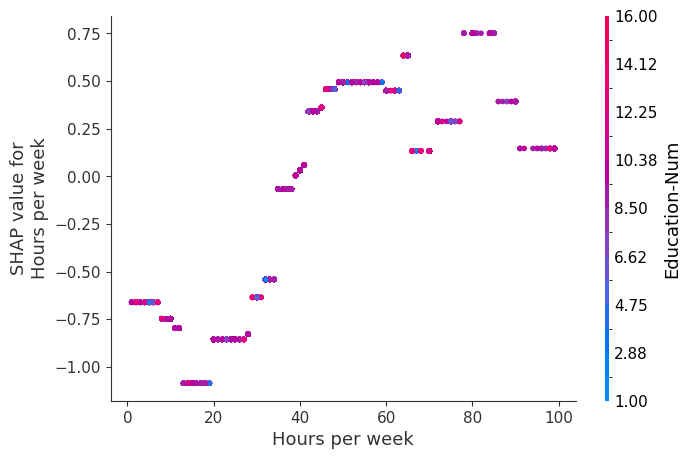

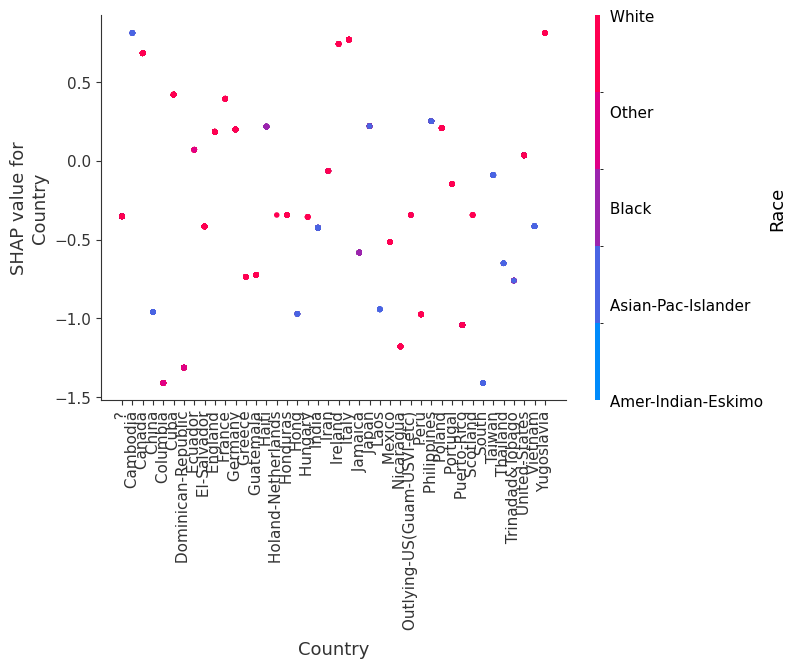

In [98]:
for name in X_train.columns:
    shap.dependence_plot(name, shap_values_ind.values, X, display_features=X_display)